In [1]:
from operator import itemgetter
from concurrent.futures import ProcessPoolExecutor 

import gensim
import arxiv
import pandas as pd

import itertools

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

from fastFM import sgd

In [2]:
lemmatizer = WordNetLemmatizer()


def stem(text):
    return lemmatizer.lemmatize(text)


def map_parallel(f, iterable, **kwargs):
    with ProcessPoolExecutor() as pool:
        result = pool.map(f, iterable, **kwargs)
    return result


def retrieve_articles(start, chunksize=1000):
    return arxiv.query(
        search_query=search_query,
        start=start,
        max_results=chunksize
    )


def extract_keywords(text):
    """
    Use gensim's textrank-based approach
    """
    return gensim.summarization.keywords(
        text=text,
        lemmatize=True,
        split=True
    )


def extract_mz_keywords(text):
    """
    Use gensim's Montemurro-Zanette method implementation
    """
    return gensim.summarization.mz_keywords(
        text=stem(text),
        blocksize=32,
        split=True
    )

Factorization machine utils

In [3]:
class FMClassifier(sgd.FMClassification):
    """
    Wrapper for fastFM estimator that makes it behave like sklearn ones
    """
    
    def fit(self, X, y, *args):
        y = y.copy()
        y[y == 0] = -1
        return super(FMClassifier, self).fit(X, y, *args)

    def predict_proba(self, X):
        probs = super(FMClassifier, self).predict_proba(X)
        return np.tile(probs, 2).reshape(2, probs.shape[0]).T
    

def predict_ovr(model, X):
    """
    predict as multiclass (standard OVR behaves as predicting multilabel)
    """
    return np.argmax(model.predict_proba(X), 1)

In [4]:
def filter_out_small_categories(df, categories, threshold=50):

    class_counts = categories.value_counts()
    too_small_classes = class_counts[class_counts < threshold].index
    too_small_classes

    valid_example_indices = ~categories.isin(too_small_classes)
    valid_examples = df[valid_example_indices]
    valid_example_categories = categories[valid_example_indices]
    
    return valid_examples, valid_example_categories

# Load ML articles from arxiv

In [5]:
%%time

search_query = 'matrix factorization'

max_n_articles = 5000 

result_chunks = list(map_parallel(
    retrieve_articles,
    range(0, max_n_articles, 1000)
))

results = list(itertools.chain(*result_chunks))

print('Retrieved {} articles'.format(len(results)))

Retrieved 5000 articles
CPU times: user 492 ms, sys: 80 ms, total: 572 ms
Wall time: 37.9 s


## Display some basic information

In [6]:
n_examples = 20

for entry in results[:n_examples]:
    print(20 * '*')
    print(entry['title'])
    print(20 * '*')
    print(', '.join(entry['authors']))
    print(entry['date'])
    print(entry['summary'])
    print()

********************
Approximate Method of Variational Bayesian Matrix
  Factorization/Completion with Sparse Prior
********************
Ryota Kawasumi, Koujin Takeda
2018-03-14T13:54:23Z
We derive analytical expression of matrix factorization/completion solution
by variational Bayes method, under the assumption that observed matrix is
originally the product of low-rank dense and sparse matrices with additive
noise. We assume the prior of sparse matrix is Laplace distribution by taking
matrix sparsity into consideration. Then we use several approximations for
derivation of matrix factorization/completion solution. By our solution, we
also numerically evaluate the performance of sparse matrix reconstruction in
matrix factorization, and completion of missing matrix element in matrix
completion.

********************
A New Method of Matrix Spectral Factorization
********************
Gigla Janashia, Edem Lagvilava, Lasha Ephremidze
2009-09-29T15:08:13Z
A new method of matrix spectral facto

In [7]:
articles_df = pd.DataFrame(results)

In [8]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
affiliation               5000 non-null object
arxiv_comment             3989 non-null object
arxiv_primary_category    5000 non-null object
arxiv_url                 5000 non-null object
author                    5000 non-null object
author_detail             5000 non-null object
authors                   5000 non-null object
doi                       2515 non-null object
guidislink                5000 non-null bool
id                        5000 non-null object
journal_reference         2163 non-null object
links                     5000 non-null object
pdf_url                   5000 non-null object
published                 5000 non-null object
published_parsed          5000 non-null object
summary                   5000 non-null object
summary_detail            5000 non-null object
tags                      5000 non-null object
title                     5000 non-null object
ti

In [9]:
articles_df.head()

,affiliation,arxiv_comment,arxiv_primary_category,arxiv_url,author,author_detail,authors,doi,guidislink,id,...,pdf_url,published,published_parsed,summary,summary_detail,tags,title,title_detail,updated,updated_parsed
0,None,"22 pages, 4 figures, part of this work was pre...","{'term': 'eess.SP', 'scheme': 'http://arxiv.or...",http://arxiv.org/abs/1803.06234v1,Koujin Takeda,{'name': 'Koujin Takeda'},"[Ryota Kawasumi, Koujin Takeda]",None,True,http://arxiv.org/abs/1803.06234v1,...,http://arxiv.org/pdf/1803.06234v1,2018-03-14T13:54:23Z,"(2018, 3, 14, 13, 54, 23, 2, 73, 0)",We derive analytical expression of matrix fact...,"{'type': 'text/plain', 'language': None, 'base...","[{'term': 'eess.SP', 'scheme': 'http://arxiv.o...",Approximate Method of Variational Bayesian Mat...,"{'type': 'text/plain', 'language': None, 'base...",2018-03-14T13:54:23Z,"(2018, 3, 14, 13, 54, 23, 2, 73, 0)"
1,None,23 pages,"{'term': 'math.CV', 'scheme': 'http://arxiv.or...",http://arxiv.org/abs/0909.5361v1,Lasha Ephremidze,{'name': 'Lasha Ephremidze'},"[Gigla Janashia, Edem Lagvilava, Lasha Ephremi...",None,True,http://arxiv.org/abs/0909.5361v1,...,http://arxiv.org/pdf/0909.5361v1,2009-09-29T15:08:13Z,"(2009, 9, 29, 15, 8, 13, 1, 272, 0)",A new method of matrix spectral factorization ...,"{'type': 'text/plain', 'language': None, 'base...","[{'term': 'math.CV', 'scheme': 'http://arxiv.o...",A New Method of Matrix Spectral Factorization,"{'type': 'text/plain', 'language': None, 'base...",2009-09-29T15:08:13Z,"(2009, 9, 29, 15, 8, 13, 1, 272, 0)"
2,None,6 pages,"{'term': 'math.CA', 'scheme': 'http://arxiv.or...",http://arxiv.org/abs/1408.2611v1,Paul W. Y. Lee,{'name': 'Paul W. Y. Lee'},[Paul W. Y. Lee],None,True,http://arxiv.org/abs/1408.2611v1,...,http://arxiv.org/pdf/1408.2611v1,2014-08-12T03:29:00Z,"(2014, 8, 12, 3, 29, 0, 1, 224, 0)","We give proofs of QR factorization, Cholesky's...","{'type': 'text/plain', 'language': None, 'base...","[{'term': 'math.CA', 'scheme': 'http://arxiv.o...",Matrix Factorizations via the Inverse Function...,"{'type': 'text/plain', 'language': None, 'base...",2014-08-12T03:29:00Z,"(2014, 8, 12, 3, 29, 0, 1, 224, 0)"
3,None,None,"{'term': 'math.CO', 'scheme': 'http://arxiv.or...",http://arxiv.org/abs/1405.6315v1,Thomas M. Richardson,{'name': 'Thomas M. Richardson'},[Thomas M. Richardson],None,True,http://arxiv.org/abs/1405.6315v1,...,http://arxiv.org/pdf/1405.6315v1,2014-05-24T16:16:58Z,"(2014, 5, 24, 16, 16, 58, 5, 144, 0)",The reciprocal Pascal matrix is the Hadamard i...,"{'type': 'text/plain', 'language': None, 'base...","[{'term': 'math.CO', 'scheme': 'http://arxiv.o...",The Reciprocal Pascal Matrix,"{'type': 'text/plain', 'language': None, 'base...",2014-05-24T16:16:58Z,"(2014, 5, 24, 16, 16, 58, 5, 144, 0)"
4,None,20 pages,"{'term': 'math.FA', 'scheme': 'http://arxiv.or...",http://arxiv.org/abs/math/0101182v2,V. V. Peller,{'name': 'V. V. Peller'},"[R. B. Alexeev, V. V. Peller]",None,True,http://arxiv.org/abs/math/0101182v2,...,http://arxiv.org/pdf/math/0101182v2,2001-01-22T23:32:55Z,"(2001, 1, 22, 23, 32, 55, 0, 22, 0)",We study the problem of invariance of indices ...,"{'type': 'text/plain', 'language': None, 'base...","[{'term': 'math.FA', 'scheme': 'http://arxiv.o...",Invariance properties of thematic factorizatio...,"{'type': 'text/plain', 'language': None, 'base...",2001-01-26T21:54:16Z,"(2001, 1, 26, 21, 54, 16, 4, 26, 0)"


## arXiv categories

In [10]:
categories = articles_df['arxiv_primary_category'].apply(itemgetter('term'))

main_categories = categories.apply(lambda s: s.split('.')[0])

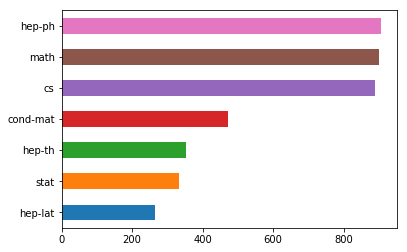

In [11]:
main_categories.value_counts(ascending=True)[-7:].plot.barh()
plt.show()

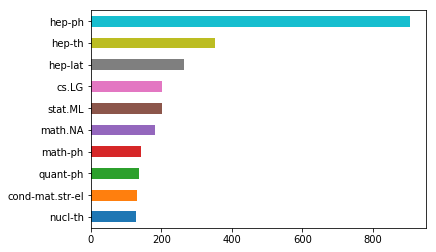

In [12]:
categories.value_counts(ascending=True)[-10:].plot.barh()
plt.show()

## Extract keywords from summaries

In [13]:
%%time

articles_df['summary_keywords'] = pd.Series(list(map_parallel(extract_keywords, articles_df['summary'])))

CPU times: user 2.51 s, sys: 290 ms, total: 2.8 s
Wall time: 52.8 s


In [14]:
for __, row in itertools.islice(articles_df.iterrows(), n_examples):
  print(20 * '*')
  print(row['title'])
  print(20 * '*')
  print('keywords:', row['summary_keywords'])
  print()

********************
Approximate Method of Variational Bayesian Matrix
  Factorization/Completion with Sparse Prior
********************
keywords: ['matrix', 'analytical', 'bayes', 'completion']

********************
A New Method of Matrix Spectral Factorization
********************
keywords: ['spectral', 'method']

********************
Matrix Factorizations via the Inverse Function Theorem
********************
keywords: ['factorizations', 'function']

********************
The Reciprocal Pascal Matrix
********************
keywords: ['pascal matrix']

********************
Invariance properties of thematic factorizations of matrix functions
********************
keywords: ['thematic', 'results', 'superoptimal', 'analytic']

********************
Online Matrix Factorization via Broyden Updates
********************
keywords: ['matrix', 'algorithms', 'objective', 'dataset', 'missing']

********************
Matrix factorizations and intertwiners of the fundamental
  representations of quantum 

In [15]:
article_keyword_lengths = articles_df['summary_keywords'].apply(len)

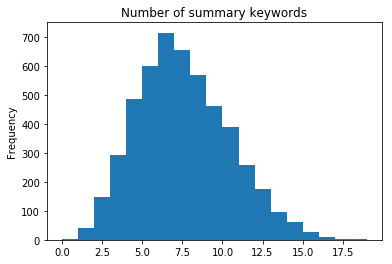

In [16]:
article_keyword_lengths.plot.hist(bins=article_keyword_lengths.max(), title='Number of summary keywords')

## Try to predict tags given summaries

In [17]:
valid_examples, valid_example_categories = filter_out_small_categories(articles_df, main_categories)

In [18]:
vectorizer = CountVectorizer(min_df=2)
vectorizer_features = vectorizer.fit_transform(valid_examples['summary'])

le = LabelEncoder()
ohe = OneHotEncoder()
categories_encoded = le.fit_transform(valid_example_categories).reshape(-1, 1)
categories_ohe = ohe.fit_transform(categories_encoded).todense()

We'll use [Factorization Machine](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf) model. FMs are well suited for such high-dimensional sparse data. This model comes from [FastFM](https://github.com/ibayer/fastFM) library.

Note `OneVsRestClassifier`. We have to use it here because FastFM doesn't support multiclass classification.

In [19]:
fm = FMClassifier(
    rank=50,
    n_iter=10000,
    step_size=0.001,
    l2_reg_w=0.01,
    l2_reg_V=0.05
)
fm_multiclass = OneVsRestClassifier(fm)

In [20]:
x_train, x_test, y_train, y_test, y_train_labels, y_test_labels = train_test_split(
    vectorizer_features,
    categories_ohe,
    categories_encoded,
    stratify=categories_encoded,
    test_size=0.1,
    random_state=0
)

In [21]:
%%time

fm_multiclass.fit(x_train, y_train)

CPU times: user 21.4 s, sys: 26.6 ms, total: 21.4 s
Wall time: 21.4 s


OneVsRestClassifier(estimator=FMClassifier(init_stdev=0.1, l2_reg=None, l2_reg_V=0.05, l2_reg_w=0.01,
       n_iter=10000, random_state=123, rank=50, step_size=0.001),
          n_jobs=1)

In [22]:
y_test_pred = predict_ovr(fm_multiclass, x_test)

In [23]:
print(
    'train score:', accuracy_score(y_train_labels, predict_ovr(fm_multiclass, x_train)), '\n'
    'test score: ', accuracy_score(y_test_labels, y_test_pred)
)

train score: 0.828847481021 
test score:  0.588842975207


In [24]:
y_pred_labels = le.inverse_transform(y_test_pred)

### Confusion matrix

Text(33,0.5,'true')

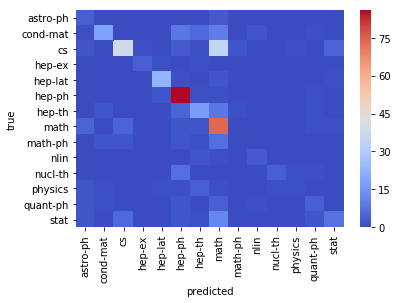

In [25]:
y_test_pred_label_names = le.inverse_transform(y_test_pred)
y_test_label_names = le.inverse_transform(y_test_labels.reshape(-1))

confusion_matrix = pd.crosstab(
    y_test_label_names,
    y_test_pred_label_names
)

sns.heatmap(
    confusion_matrix,
    cmap='coolwarm'
)
plt.xlabel('predicted')
plt.ylabel('true')